## **Purpose**
### In this notebook we will be Comparing Critc ratings to User ratings.
## **Datasets**
### 500.csv

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
if not os.path.exists("../data/500.csv"):
    print("Missing dataset file")
else:
    print("Success!")

Success!


In [3]:
df = pd.read_csv("../data/prep/500.csv")

### User Score only goes up to 10 so by multiplying it by 10 it will be in the same fromat as critic score.

In [4]:
# multiply the user_score by 10 to make it comparable to critic score
df["meta_user_score"] = df.meta_user_score * 10

C:\Users\Sean Harkin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


,meta_critic_score,meta_user_score
meta_critic_score,1.000000,0.508976
meta_user_score,0.508976,1.000000


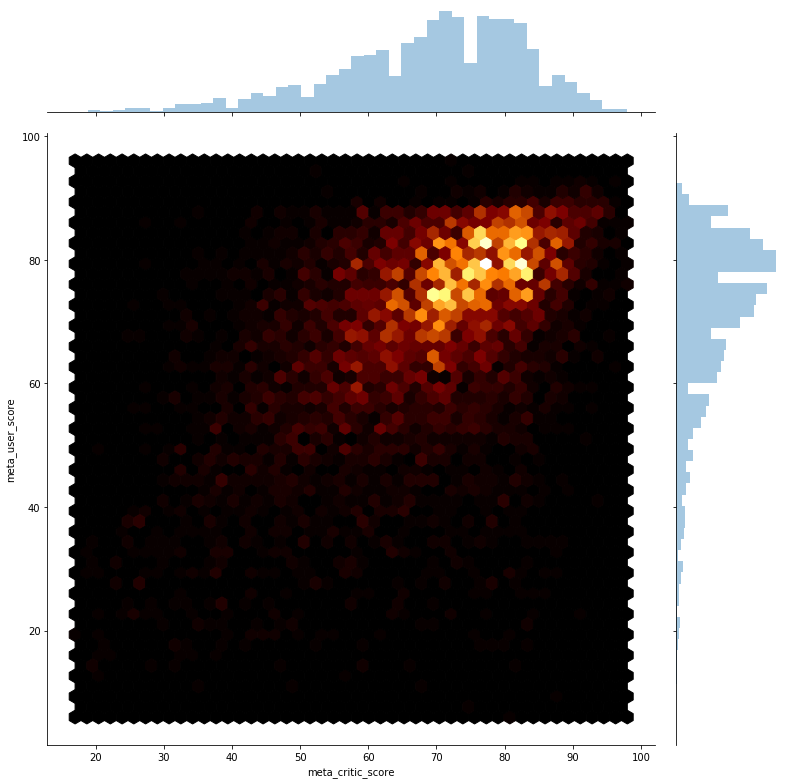

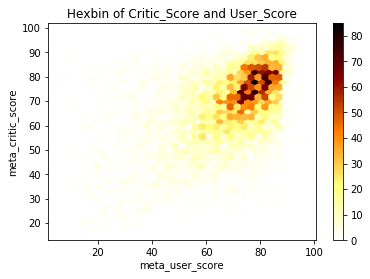

In [5]:
sns.jointplot(x='meta_critic_score',y='meta_user_score',data=df,
              kind='hex', cmap= 'afmhot', size=11)
df.plot(y= 'meta_critic_score', x ='meta_user_score',kind='hexbin',gridsize=35, 
          sharex=False, colormap='afmhot_r', title='Hexbin of Critic_Score and User_Score')

df[['meta_critic_score','meta_user_score']].corr()

Text(65, 320, 'median')

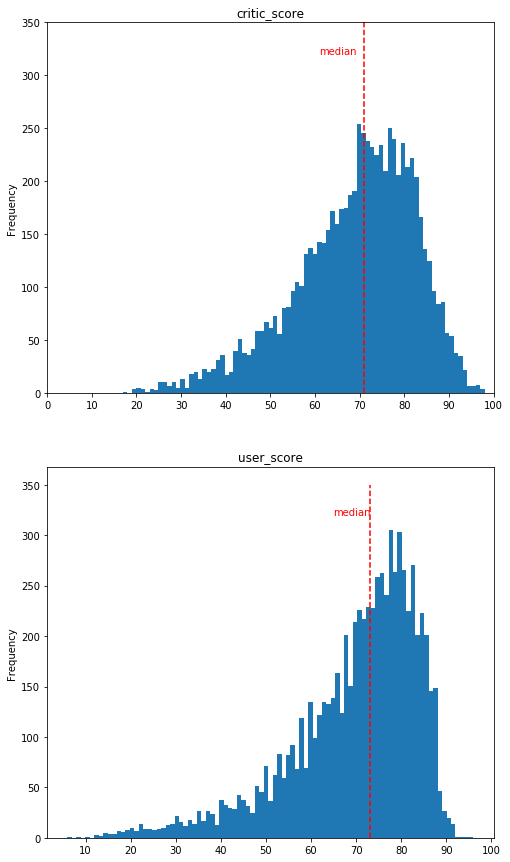

In [6]:
fig, ax = plt.subplots(2,1, figsize=(8,15))

user_scores = int(df.meta_user_score.max() - df.meta_user_score.min() + 1)
critic_scores = int(df.meta_critic_score.max() - df.meta_critic_score.min() + 1)

plot_1 = df.meta_critic_score.plot(kind="hist", bins=critic_scores, title="critic_score", 
                              ax=ax[0], xticks=range(0,110,10), ylim=(0,350), xlim=(0,100))
plot_1.vlines(df.meta_critic_score.median(), 0, 350, color="r", linestyle="--")
plot_1.text(61, 320, "median", color="r")

plot_2 = df.meta_user_score.plot(kind="hist", bins=user_scores, title="user_score", ax=ax[1], xticks=range(0,110,10))
plot_2.vlines(df.meta_user_score.median(), 0, 350, color="r", linestyle="--")
plot_2.text(65, 320, "median", color="r")

### Overall, the users (median = 74) rate the games with higher scores compared to the critics (median = 71). This is mainly due to the fact that the frequency of games with a score around 80 is significantly higher (close to and above 250). But there are also games with an extremely low score of less than 10 which causes the distribution of the user score to be somewhat more left-skewed.

### Let's now have a look at the distribution of the actual difference between the two scores for any given game:

In [7]:
# the difference is determined by subtracting the critic score from the user score
df["difference"] = df.meta_user_score - df.meta_critic_score

Text(20, 275, 'critic score < user score')

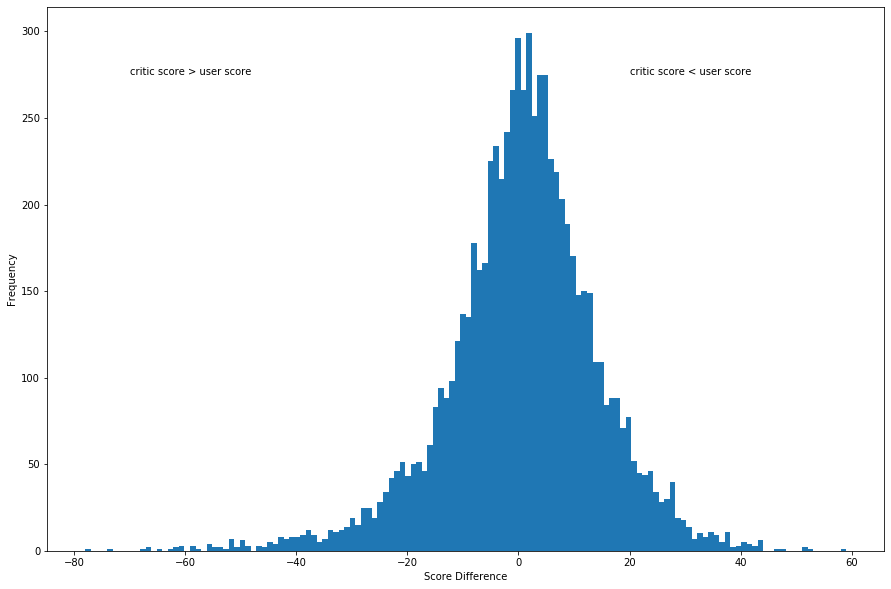

In [8]:
differences = int(df.difference.max() + abs(df.difference.min()) + 1)

df.difference.plot(kind="hist", bins=differences, figsize=(15,10))
plt.xlabel("Score Difference")
plt.text(-70, 275, "critic score > user score")
plt.text(20, 275, "critic score < user score")

### As expected, this looks like a normal distribution with most games having a difference between the two scores of around zero. There are also somewhat more games on the right side of this distribution since (as shown above) users tend to give a higher score than critics.

### A score difference of 20 and more means that the users gave a much higher score than the critics. Let's call them "Evangelists". A score difference of -20 and less, on the other hand, means that the users gave a much lower score than the critics. Let's call them "Haters".

### So let's now have a closer look at those tails of the distribution:

In [9]:
# create categories in regards to the tails of the score difference histogram
def determine_influence(difference):
    if difference < -20:
        return "Haters" 
    if difference > 20:
        return "Evangelists"
    else:
        return "Neutral"

In [10]:
df["user_score_influenced_by"] = df.difference.apply(determine_influence)

C:\Users\Sean Harkin\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 20.800000000000026, 'Score Difference')

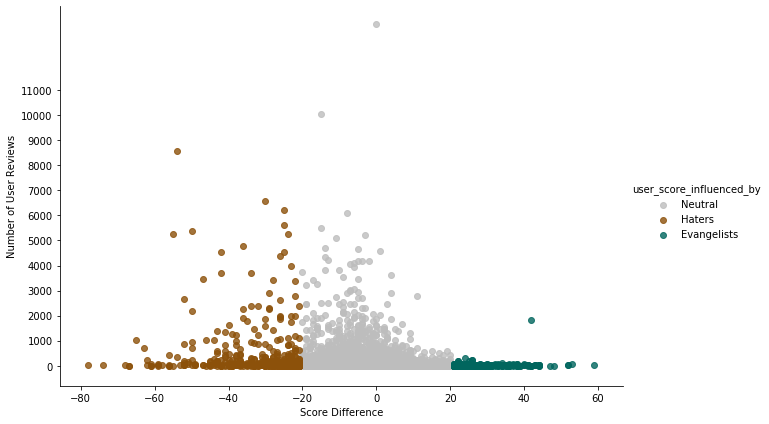

In [11]:
sns.lmplot(data=df, x="difference", y="meta_user_count", hue="user_score_influenced_by", palette=["#bdbdbd", "#8c510a", "#01665e"],
           fit_reg=False, size=6, aspect=1.5)

plt.yticks(range(0,12000,1000))
plt.ylabel("Number of User Reviews")
plt.xlabel("Score Difference")

### One can clearly see that games where the user score was influenced by evangelists only occur where there are not so many user reviews (below 500), i.e. games that are probably not so famous. Games where the user score was influenced by haters, on the other hand, also occur where there are more than 500 user reviews.

### Let's look at the same graph, only this time, with a logarithmic scale:

In [12]:
df["log10_user_count"] = np.log10(df.meta_user_count)

Text(0.5, 20.800000000000026, 'Score Difference')

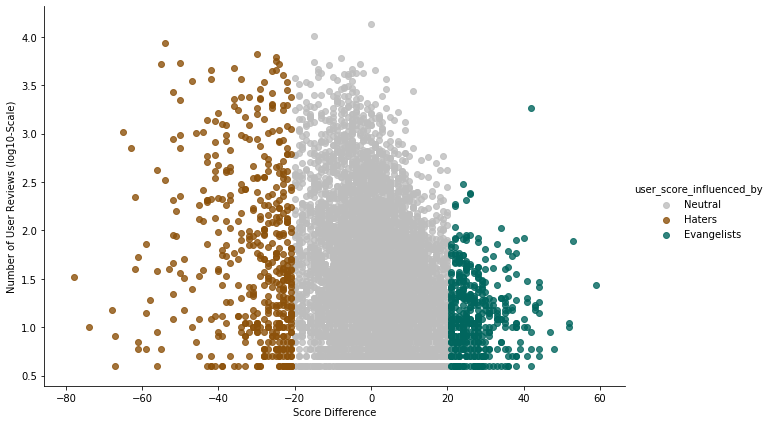

In [13]:
sns.lmplot(data=df, x="difference", y="log10_user_count", hue="user_score_influenced_by", palette=["#bdbdbd", "#8c510a", "#01665e"],
           fit_reg=False, size=6, aspect=1.5)

plt.ylabel("Number of User Reviews (log10-Scale)")
plt.xlabel("Score Difference")

### Here, it looks like that the number of games where the user score was influenced by evangelists seems to decrease as the number of user reviews increases. Hater-influenced games seem to be more or less distributed evenly across the number of user reviews (with some peaks at around 1.5 and between 3.5 - 4.0)

### Let's use the yticks as bins and see how the proportions of evangelist- and hater-influenced games change as the number of user reviews increases:

In [14]:
df["log_bins"] = pd.cut(df.log10_user_count, bins=[0.5,1,1.5,2,2.5,3,3.5,4.5])

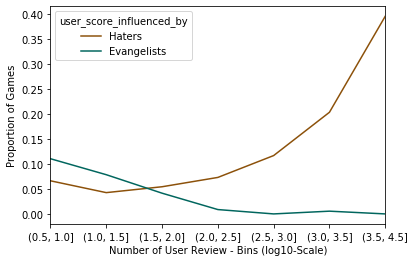

In [15]:
proportions = pd.crosstab(df.log_bins, df.user_score_influenced_by)
proportions.div(proportions.sum(1), axis=0)[["Haters", "Evangelists"]] \
           .plot(color=["#8c510a", "#01665e"]) \
           .set(ylabel="Proportion of Games", xlabel="Number of User Review - Bins (log10-Scale)")
plt.show()

### Here, the pattern is even more obvious. As the number of user reviews increases, the proportion of games where the user score was influenced by haters increases sharply, especially towards the last two bins. The proportion of hater-influenced user scores for the last group is close to 40%. Hence, the more famous a game is, the more haters it tends to attract.

### The proportion of games where the user score was influenced by evangelists, on the other hand, decreases as the number of user reviews increases. The highest proportion of evangelists occurs for the bin representing the lowest number of user reviews. This makes sense since these games are not so famous, so you tend to know them only if you're interested in them. Thus, haters simply don't know them and the evangelists don't get outnumbered by the haters.

## **Are critics more objective than users?**
### We've seen that user reviews can potentially be heavily influenced by users who create a review just to hate on the game. So, are the critics more objective?

[Text(0, 0.5, 'Critic Score'),
 Text(0.5, 0, 'Number of User Review - Bins (log10-Scale)')]

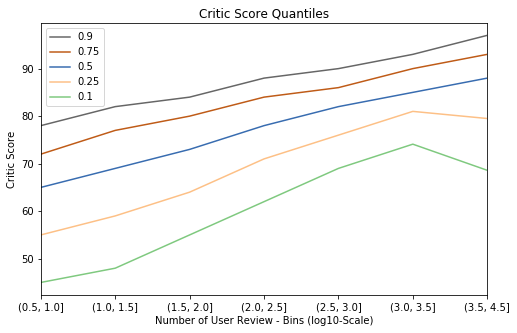

In [16]:
df.groupby("log_bins")["meta_critic_score"].quantile([0.1,0.25,0.5,0.75,0.9]).unstack() \
  .plot(figsize=(8,5), legend="reverse", title="Critic Score Quantiles", cmap="Accent") \
  .set(ylabel="Critic Score", xlabel="Number of User Review - Bins (log10-Scale)")

### This graph depicts different quantiles of the critic score across the different (former determined) bins of number of user reviews. There, are two patterns emerging. The first is that all the quantiles increase as the number of user reviews increases. This makes sense since more famous games tend to have a bigger development budget and bigger companies working on it and therefore they should be able to produce better games. The second pattern is that the lines all move more or less in parallel. This hints at a somewhat more obejective review process.

### Let's look at the same diagram but this time using the user score:

[Text(0, 0.5, 'User Score'),
 Text(0.5, 0, 'Number of User Review - Bins (log10-Scale)')]

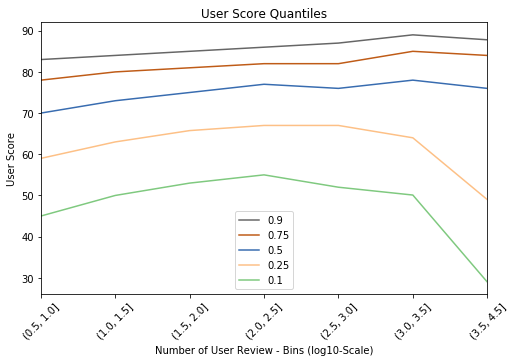

In [17]:
df.groupby("log_bins")["meta_user_score"].quantile([0.1,0.25,0.5,0.75,0.9]).unstack() \
  .plot(figsize=(8,5), legend="reverse", rot=45, title="User Score Quantiles", cmap="Accent") \
  .set(ylabel="User Score", xlabel="Number of User Review - Bins (log10-Scale)")

### Here, the abovementioned first pattern is not so stark. The top-three lines increase only slightly. This is because, as mentioned above, users overall tend to give a higher score and therefore the potential for an increasing score is smaller.

### Even more important, the second pattern (lines moving in parallel) also doesn't hold true anymore. The 0.1 and 0.25 quantiles even start to decrease again and the decline is especially sharp for the last bin. This is because this bin has the highest proportion of hater-influenced user scores for the games.

## **Conclusion**
### Since the line plots for the critic score move more or less in parallel and don't show the obvious pattern that the bottom 10% of reviews give an exceptionally bad score for more famous games (like it happens for user scores), the critics seem to be more objective. Even though, they give a low score, they still look for some good points and don't just view everything negatively about the game. For the remainder of the project we will be using critic ratings to show what rating a game is.